In [1]:

# should permanantly add this path to pythonpath instead
import sys
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book')
import matplotlib.pyplot as plt

#########

from dataclasses import dataclass
from typing import Callable, Sequence, Tuple, Iterator, List
import numpy as np
from scipy.stats import norm
from rl.distribution_fred import SampledDistribution
from rl.markov_decision_process import MarkovDecisionProcess, \
    NonTerminal, State, Terminal
from rl.policy import DeterministicPolicy
from rl.function_approx_fred import FunctionApprox, LinearFunctionApprox, LinearInterpolationApprox, BSplineApprox
from rl.approximate_dynamic_programming_fred import back_opt_vf_and_policy
from numpy.polynomial.laguerre import lagval

import copy # for analysis deepcopy


# bspline for call option

In [47]:
# the following was modified to allow for linear interpolation


@dataclass(frozen=True)
class OptimalExerciseBI:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float

    def european_price(self, is_call: bool, strike: float) -> float:
        """
        Compute the price of an european option (put or call) computed using BS solution.
        """
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseBIMDP(MarkovDecisionProcess[float, bool]):

            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=200 # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseBIMDP()

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))  

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                                        np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
#                                         self.vol * np.sqrt(time)
                                        self.vol * np.sqrt(time)*4  # I modified this line to have more variance (added the *1.1)
                                            )
                          )
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)

# the function below is not needed anymore

#     def get_vf_func_approx(
#         self,
#         t: int,
#         features: Sequence[Callable[[NonTerminal[float]], float]],
#         reg_coeff: float
#     ) -> LinearFunctionApprox[NonTerminal[float]]:
#         return LinearFunctionApprox.create(
#             feature_functions=features,
#             regularization_coeff=reg_coeff,
#             direct_solve=True
#         )

    # this was modified to allow for linear interpolation
    def backward_induction_vf_and_pi(
        self,
        is_call: bool
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        if is_call:
            mdp_f0_mu_triples: Sequence[Tuple[
                MarkovDecisionProcess[float, bool],
                FunctionApprox[NonTerminal[float]],
                SampledDistribution[NonTerminal[float]]
            ]] = [(
                self.get_mdp(t=i),
                BSplineApprox(lambda s: s.state,
                              3,
                              25.0,                   # I added this (third) parameter which is a smoothing parameter
                              mode = "increasing"),    # I set it to be 10% of the num_state_samples, it seems like 10% is
                self.get_states_distribution(t=i)      # wrong for call options
            ) for i in range(self.num_steps + 1)]      # also notice how here the curve is increasing instead of decreasing

            num_state_samples: int = 1000 #1000

            return back_opt_vf_and_policy(
                mdp_f0_mu_triples=mdp_f0_mu_triples,
                γ=np.exp(-self.rate * self.expiry / self.num_steps),
                num_state_samples=num_state_samples,
                error_tolerance=1e-8,
                mode = "call"
            )
        else:
            mdp_f0_mu_triples: Sequence[Tuple[
                MarkovDecisionProcess[float, bool],
                FunctionApprox[NonTerminal[float]],
                SampledDistribution[NonTerminal[float]]
            ]] = [(
                self.get_mdp(t=i),
                BSplineApprox(lambda s: s.state,
                              3,
                              25.0,                   # I added this (third) parameter which is a smoothing parameter
                              mode = "decreasing"),    # I set it to be 10% of the num_state_samples, it seems like 10% is
                self.get_states_distribution(t=i)      # wrong for call options
            ) for i in range(self.num_steps + 1)]      # also notice how here the curve is increasing instead of decreasing

            num_state_samples: int = 1000 #1000

            return back_opt_vf_and_policy(
                mdp_f0_mu_triples=mdp_f0_mu_triples,
                γ=np.exp(-self.rate * self.expiry / self.num_steps),
                num_state_samples=num_state_samples,
                error_tolerance=1e-8,
                mode = "put"
            )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    # I modifed this function to add a tolerance
    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float,
        tol: float = 0
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e+tol > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret





############################################################################################




spot_price_val: float = 100.0 #100
strike: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.02 #0.02
is_call: bool = True
    
# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda x: max(x - strike, 0)
else:
    opt_payoff = lambda x: max(strike - x, 0)
    


opt_ex_bi: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val,
    spot_price_frac=spot_price_frac_val
)

# here I used to get an iterator of the optimal value functions and the associated optimal policy,
# but now I get an iterator of the continuation value functions, the optimal value function, and the optimal policy for this step
# when plotting the following, you should observe that the payoff function crosses the continuation at the policy number.
it_vf = opt_ex_bi.backward_induction_vf_and_pi(is_call)

prices: np.ndarray = np.arange(50,250.0)

print("Backward Induction: VF And Policy")
print("---------------------------------")
print()

all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, v_cont, v_exec, p) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()

#     # plot the continuation value function at time t(value function if action = False)
#     v_cont_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
#         func=v_cont,
#         prices=prices
#     )

#     plt.plot(
#         prices,
#         v_cont_curve,
#         "g"
#     )

    
#     # plot the execution value function at time t(value function if action = True)
#     v_exec_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
#         func=v_exec,
#         prices=prices
#     )

#     plt.plot(
#         prices,
#         [max(p-100.0, 0.0) for p in prices],
#         "r"
#     )
    
#     # plot the optimal value function at time t
#     v_opt_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
#         func=v_opt,
#         prices=prices
#     )

#     plt.scatter(
#         prices,
#         v_opt_curve,
#         color = "b",
#         s = 5
#     )


#     time: float = t * expiry_val / num_steps_val
#     plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
#     plt.show()

    all_funcs.append(v_opt)

#     opt_alloc: float = p.action_for(spot_price_val)
    val: float = v_opt(NonTerminal(spot_price_val))
    print(f"Opt Val = {val:.3f}")
    print()

# ex_bound: Sequence[float] = opt_ex_bi.put_option_exercise_boundary(
#     all_funcs,
#     strike
# )
# plt.scatter(range(num_steps_val + 1), ex_bound)
# plt.title("Exercise Boundary")
# plt.show()

print("European Call Price")
print("------------------")
print()
print(opt_ex_bi.european_price(is_call=is_call, strike=strike)) # notice how I changed the function being called here


Backward Induction: VF And Policy
---------------------------------

Time 0

Opt Val = 11.459

Time 1

Opt Val = 11.739

Time 2

Opt Val = 11.219

Time 3

Opt Val = 9.955

Time 4

Opt Val = 9.111

Time 5

Opt Val = 7.958

Time 6

Opt Val = 7.034

Time 7

Opt Val = 6.446

Time 8

Opt Val = 4.957

Time 9

Opt Val = 3.674

Time 10

Opt Val = 1.274

European Call Price
------------------

12.335998930368717


In [ ]:
it_vf = list(it_vf)

In [20]:
[it_vf[0][3].act(NonTerminal(p)) for p in prices]

ValueError: Need at least two internal knots.

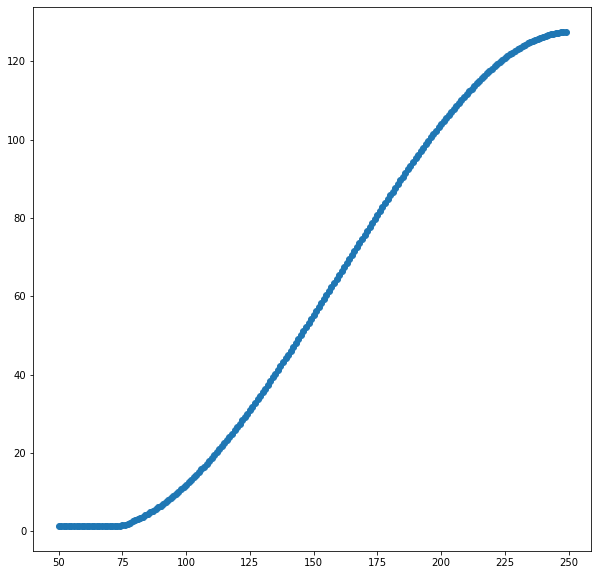

11.945081624096064


In [22]:
plt.figure(figsize=(10,10))
plt.scatter(prices,it_vf[0][0].evaluate([NonTerminal(p) for p in prices]))
plt.show()
print(it_vf[0][0](NonTerminal(100)))
# it breaks is it because of my monotonic constraint (done wrong)

# bspline (call and put) (this is the good section)

Backward Induction: VF And Policy
---------------------------------

Time 0



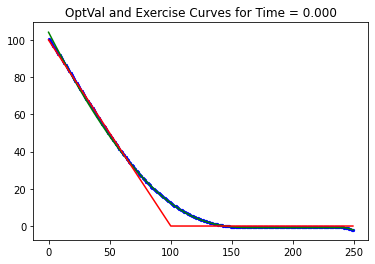

Opt Action = False, Opt Val = 12.363

Time 1



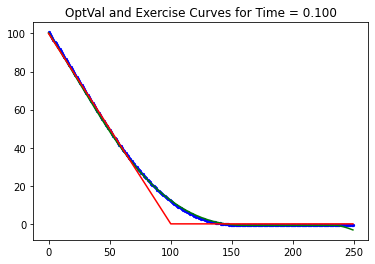

Opt Action = False, Opt Val = 11.908

Time 2



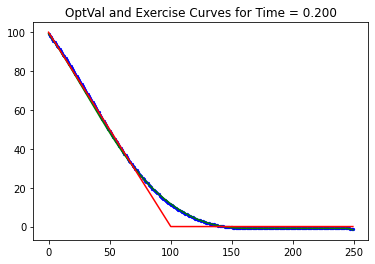

Opt Action = False, Opt Val = 11.336

Time 3



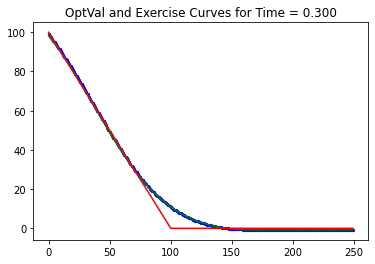

Opt Action = False, Opt Val = 10.795

Time 4



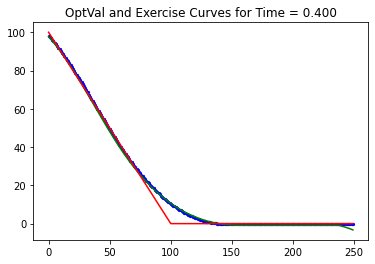

Opt Action = False, Opt Val = 10.403

Time 5



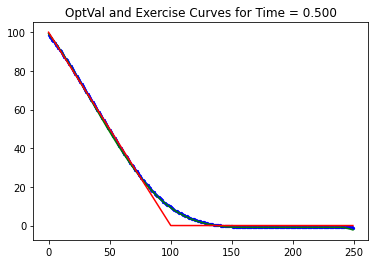

Opt Action = False, Opt Val = 9.472

Time 6



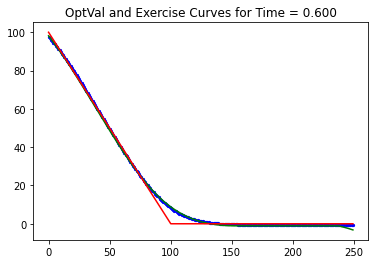

Opt Action = False, Opt Val = 8.178

Time 7



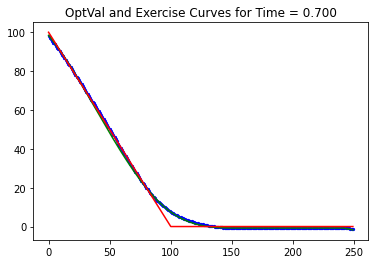

Opt Action = False, Opt Val = 7.567

Time 8



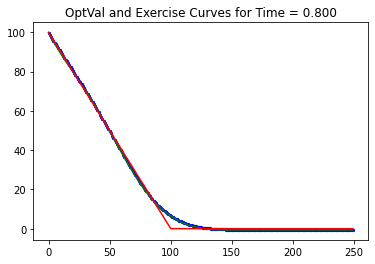

Opt Action = False, Opt Val = 6.525

Time 9



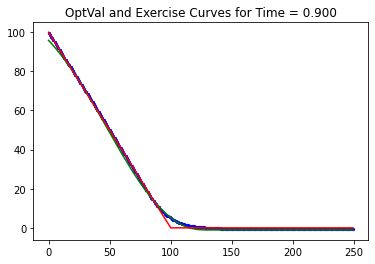

Opt Action = False, Opt Val = 4.935

Time 10



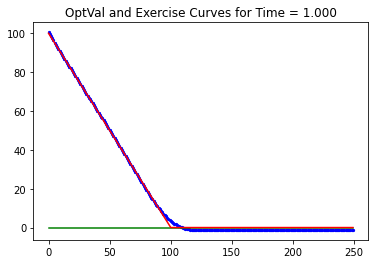

Opt Action = False, Opt Val = 3.397



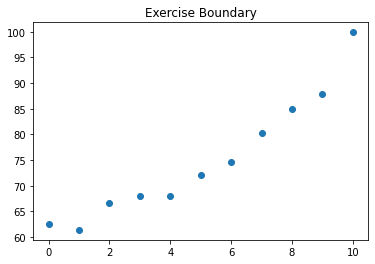

American Put Price using ADP
------------------
12.363383025122978

European Put Price using B-S
------------------
7.458941380440123



In [2]:
# the following was modified to allow for linear interpolation


@dataclass(frozen=True)
class OptimalExerciseBI:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float

    def european_price(self, is_call: bool, strike: float) -> float:
        """
        Compute the price of an european option (put or call) computed using BS solution.
        """
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseBIMDP(MarkovDecisionProcess[float, bool]):

            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=200 # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseBIMDP()

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
                self.vol * np.sqrt(time)*4
#                 self.vol * np.sqrt(time)*1.1  # I modified this line to have more variance (added the *1.1)
            ))
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)

# the function below is not needed anymore

#     def get_vf_func_approx(
#         self,
#         t: int,
#         features: Sequence[Callable[[NonTerminal[float]], float]],
#         reg_coeff: float
#     ) -> LinearFunctionApprox[NonTerminal[float]]:
#         return LinearFunctionApprox.create(
#             feature_functions=features,
#             regularization_coeff=reg_coeff,
#             direct_solve=True
#         )

    # this was modified to allow for linear interpolation
    def backward_induction_vf_and_pi(
        self,
        is_call: bool
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        if is_call:
            mdp_f0_mu_triples: Sequence[Tuple[
                MarkovDecisionProcess[float, bool],
                FunctionApprox[NonTerminal[float]],
                SampledDistribution[NonTerminal[float]]
            ]] = [(
                self.get_mdp(t=i),
                BSplineApprox(lambda s: s.state,
                              3,
                              50.0,                   # I added this (third) parameter which is a smoothing parameter
                              mode = "increasing"),    # I set it to be 10% of the num_state_samples, it seems like 10% is
                self.get_states_distribution(t=i)      # wrong for call options
            ) for i in range(self.num_steps + 1)]      # also notice how here the curve is increasing instead of decreasing

            num_state_samples: int = 1000 #1000

            return back_opt_vf_and_policy(
                mdp_f0_mu_triples=mdp_f0_mu_triples,
                γ=np.exp(-self.rate * self.expiry / self.num_steps),
                num_state_samples=num_state_samples,
                error_tolerance=1e-8,
                mode = "call"
            )
        else:
            mdp_f0_mu_triples: Sequence[Tuple[
                MarkovDecisionProcess[float, bool],
                FunctionApprox[NonTerminal[float]],
                SampledDistribution[NonTerminal[float]]
            ]] = [(
                self.get_mdp(t=i),
                BSplineApprox(lambda s: s.state,
                              3,
                              25.0,                   # I added this (third) parameter which is a smoothing parameter
                              mode = "decreasing"),    # I set it to be 10% of the num_state_samples, it seems like 10% is
                self.get_states_distribution(t=i)      # wrong for call options
            ) for i in range(self.num_steps + 1)]      # also notice how here the curve is increasing instead of decreasing

            num_state_samples: int = 100 #1000

            return back_opt_vf_and_policy(
                mdp_f0_mu_triples=mdp_f0_mu_triples,
                γ=np.exp(-self.rate * self.expiry / self.num_steps),
                num_state_samples=num_state_samples,
                error_tolerance=1e-8,
                mode = "put"
            )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    # I modifed this function to add a tolerance
    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float,
        tol: float = 0
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e+tol > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret





############################################################################################




spot_price_val: float = 100.0 #100
strike: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.02 #0.02
    
is_call: bool = False
    
# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda x: max(x - strike, 0)
else:
    opt_payoff = lambda x: max(strike - x, 0)

opt_ex_bi: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val,
    spot_price_frac=spot_price_frac_val
)

# here I used to get an iterator of the optimal value functions and the associated optimal policy,
# but now I get an iterator of the continuation value functions, the optimal value function, and the optimal policy for this step
# when plotting the following, you should observe that the payoff function crosses the continuation at the policy number.
it_vf = opt_ex_bi.backward_induction_vf_and_pi(is_call)

print("Backward Induction: VF And Policy")
print("---------------------------------")
print()
prices: np.ndarray = np.arange(250.0)
all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, v_cont, v_exec, p) in enumerate(it_vf):

    print(f"Time {t:d}")
    print()

    # plot the continuation value function at time t(value function if action = False)
    v_cont_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_cont,
        prices=prices
    )

    plt.plot(
        prices,
        v_cont_curve,
        "g"
    )


    # plot the execution value function at time t(value function if action = True)
    v_exec_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_exec,
        prices=prices
    )

    plt.plot(
        prices,
        [max(100.0-p, 0.0) for p in prices],
        "r"
    )

    # plot the optimal value function at time t
    v_opt_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_opt,
        prices=prices
    )

    plt.scatter(
        prices,
        v_opt_curve,
        color = "b",
        s = 5
    )


    time: float = t * expiry_val / num_steps_val
    plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
    plt.show()

    all_funcs.append(v_opt)

    opt_alloc: float = p.action_for(spot_price_val)
    val: float = v_opt(NonTerminal(spot_price_val))
    print(f"Opt Action = {opt_alloc}, Opt Val = {val:.3f}")
    print()
        
if not is_call:
    ex_bound: Sequence[float] = opt_ex_bi.put_option_exercise_boundary(
        all_funcs,
        strike
    )
    plt.scatter(range(num_steps_val + 1), ex_bound)
    plt.title("Exercise Boundary")
    plt.show()
    
    val:float = all_funcs[0](NonTerminal(spot_price_val))
    print(f"American Put Price using ADP")
    print("------------------")
    print(val)
    print()
    
    print("European Put Price using B-S")
    print("------------------")
    print(opt_ex_bi.european_price(is_call=is_call, strike=strike))
    print()

else:
    # TODO: it seems like the call option work better with ADP when the num_state_samples=100, when it is 
    # around 1000, the results are worse, and bspline complains that the smoothing s is too small (RuntimeError: A theoretically 
    # impossible result when finding a smoothing spline)

    vfs = list(it_vf)
    v_opt = vfs[0][0]
    val:float = v_opt(NonTerminal(spot_price_val))
    print(f"American Call Price using ADP")
    print("------------------")
    print(val)
    print()
    
    print("European Call Price using B-S")
    print("------------------")
    print(opt_ex_bi.european_price(is_call=is_call, strike=strike))
    print()

    
    



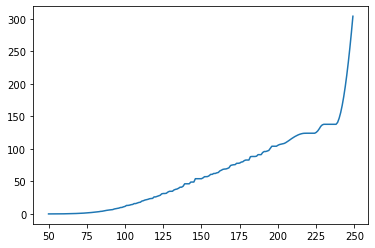

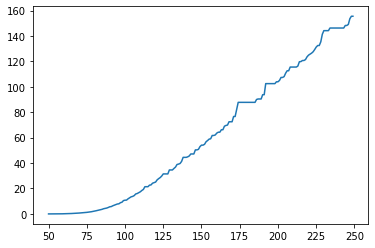

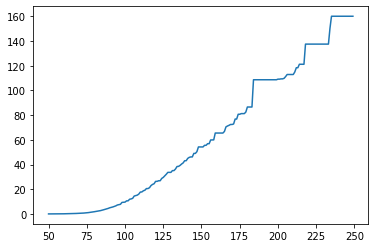

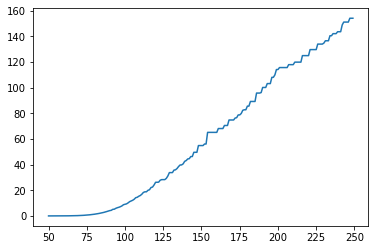

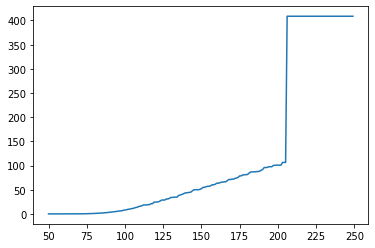

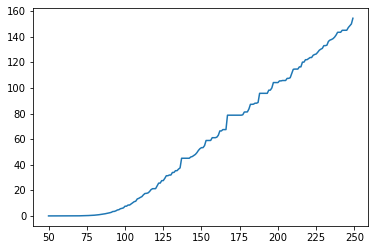

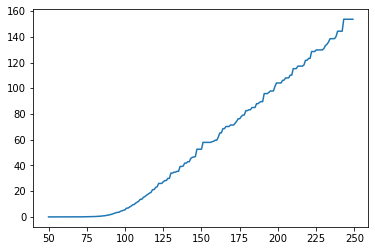

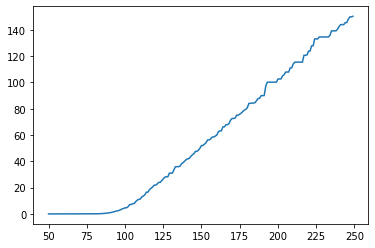

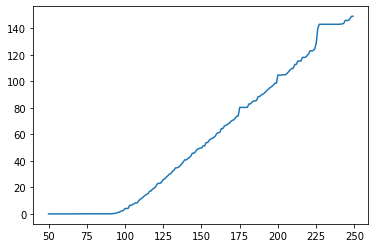

In [71]:
for i in range(1,num_steps_val):
    plt.plot(prices, vfs[i][0].evaluate([NonTerminal(p) for p in prices]))
    plt.show()

In [81]:
# the following was modified to allow for linear interpolation


@dataclass(frozen=True)
class OptimalExerciseBI:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float

    def european_price(self, is_call: bool, strike: float) -> float:
        """
        Compute the price of an european option (put or call) computed using BS solution.
        """
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseBIMDP(MarkovDecisionProcess[float, bool]):

            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=200 # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseBIMDP()

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
                self.vol * np.sqrt(time)*5
#                 self.vol * np.sqrt(time)*1.1  # I modified this line to have more variance (added the *1.1)
            ))
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)

# the function below is not needed anymore

#     def get_vf_func_approx(
#         self,
#         t: int,
#         features: Sequence[Callable[[NonTerminal[float]], float]],
#         reg_coeff: float
#     ) -> LinearFunctionApprox[NonTerminal[float]]:
#         return LinearFunctionApprox.create(
#             feature_functions=features,
#             regularization_coeff=reg_coeff,
#             direct_solve=True
#         )

    # this was modified to allow for linear interpolation
    def backward_induction_vf_and_pi(
        self,
        is_call: bool
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        if is_call:
            mdp_f0_mu_triples: Sequence[Tuple[
                MarkovDecisionProcess[float, bool],
                FunctionApprox[NonTerminal[float]],
                SampledDistribution[NonTerminal[float]]
            ]] = [(
                self.get_mdp(t=i),
                BSplineApprox(lambda s: s.state,
                              3,
                              50.0,                   # I added this (third) parameter which is a smoothing parameter
                              mode = "increasing"),    # I set it to be 10% of the num_state_samples, it seems like 10% is
                self.get_states_distribution(t=i)      # wrong for call options
            ) for i in range(self.num_steps + 1)]      # also notice how here the curve is increasing instead of decreasing

            num_state_samples: int = 1000 #1000

            return back_opt_vf_and_policy(
                mdp_f0_mu_triples=mdp_f0_mu_triples,
                γ=np.exp(-self.rate * self.expiry / self.num_steps),
                num_state_samples=num_state_samples,
                error_tolerance=1e-8,
                mode = "call"
            )
        else:
            mdp_f0_mu_triples: Sequence[Tuple[
                MarkovDecisionProcess[float, bool],
                FunctionApprox[NonTerminal[float]],
                SampledDistribution[NonTerminal[float]]
            ]] = [(
                self.get_mdp(t=i),
                BSplineApprox(lambda s: s.state,
                              3,
                              25.0,                   # I added this (third) parameter which is a smoothing parameter
                              mode = "decreasing"),    # I set it to be 10% of the num_state_samples, it seems like 10% is
                self.get_states_distribution(t=i)      # wrong for call options
            ) for i in range(self.num_steps + 1)]      # also notice how here the curve is increasing instead of decreasing

            num_state_samples: int = 1000 #1000

            return back_opt_vf_and_policy(
                mdp_f0_mu_triples=mdp_f0_mu_triples,
                γ=np.exp(-self.rate * self.expiry / self.num_steps),
                num_state_samples=num_state_samples,
                error_tolerance=1e-8,
                mode = "put"
            )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    # I modifed this function to add a tolerance
    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float,
        tol: float = 0
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e+tol > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret





############################################################################################
 

Backward Induction: VF And Policy
---------------------------------

Time 0



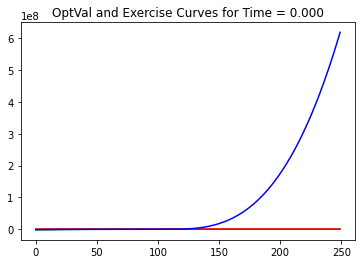

Opt Action = False, Opt Val = 12.852

Time 1



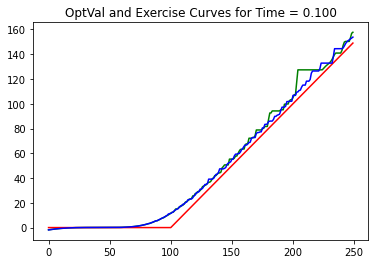

Opt Action = False, Opt Val = 11.456

Time 2



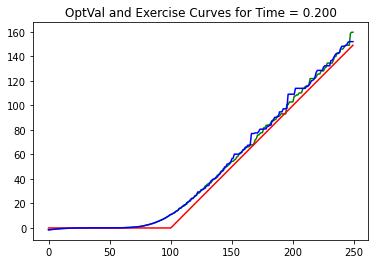

Opt Action = False, Opt Val = 10.836

Time 3



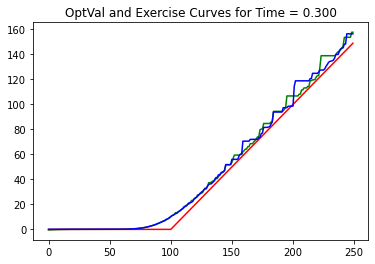

Opt Action = False, Opt Val = 10.132

Time 4



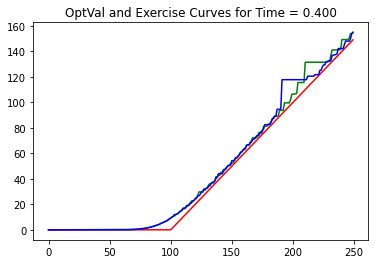

Opt Action = False, Opt Val = 9.268

Time 5



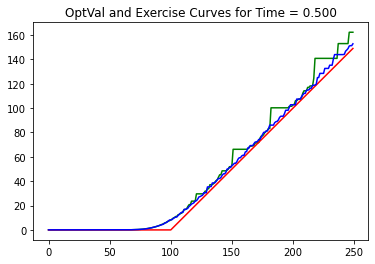

Opt Action = False, Opt Val = 8.054

Time 6



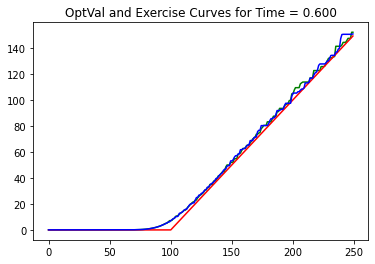

Opt Action = False, Opt Val = 7.107

Time 7



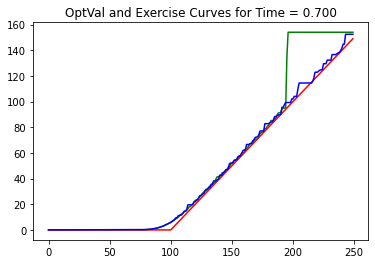

Opt Action = False, Opt Val = 6.025

Time 8



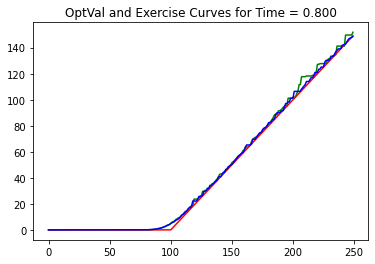

Opt Action = False, Opt Val = 4.874

Time 9



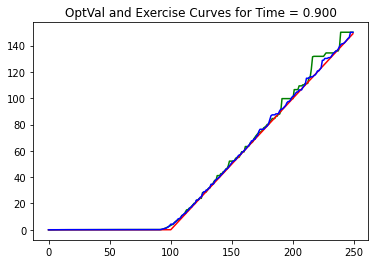

Opt Action = False, Opt Val = 4.218

Time 10



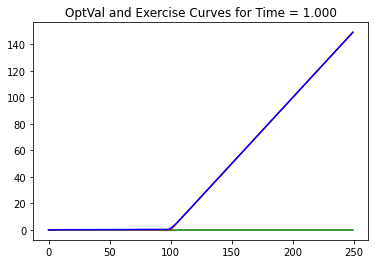

Opt Action = False, Opt Val = 1.222

American Call Price using ADP
------------------
12.852312338828376

European Call Price using B-S
------------------
12.335998930368717



In [86]:
# call option
spot_price_val: float = 100.0 #100
strike: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.02 #0.02 TODO: bspline breaks if I dont have that
    
is_call: bool = True
    
# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda x: max(x - strike, 0)
else:
    opt_payoff = lambda x: max(strike - x, 0)

opt_ex_bi: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val,
    spot_price_frac=spot_price_frac_val
)

# here I used to get an iterator of the optimal value functions and the associated optimal policy,
# but now I get an iterator of the continuation value functions, the optimal value function, and the optimal policy for this step
# when plotting the following, you should observe that the payoff function crosses the continuation at the policy number.
it_vf = opt_ex_bi.backward_induction_vf_and_pi(is_call)

print("Backward Induction: VF And Policy")
print("---------------------------------")
print()
prices: np.ndarray = np.arange(250.0)
all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, v_cont, v_exec, p) in enumerate(it_vf):

    print(f"Time {t:d}")
    print()

    # plot the continuation value function at time t(value function if action = False)
    v_cont_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_cont,
        prices=prices
    )

    plt.plot(
        prices,
        v_cont_curve,
        "g"
    )


    # plot the execution value function at time t(value function if action = True)
    v_exec_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_exec,
        prices=prices
    )

    plt.plot(
        prices,
        [opt_payoff(p) for p in prices],
        "r"
    )

    # plot the optimal value function at time t
    v_opt_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_opt,
        prices=prices
    )

    plt.plot(
        prices,
        v_opt_curve,
        color = "b"
    )


    time: float = t * expiry_val / num_steps_val
    plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
    plt.show()

    all_funcs.append(v_opt)

    opt_alloc: float = p.action_for(spot_price_val)
    val: float = v_opt(NonTerminal(spot_price_val))
    print(f"Opt Action = {opt_alloc}, Opt Val = {val:.3f}")
    print()
        
if not is_call:
    ex_bound: Sequence[float] = opt_ex_bi.put_option_exercise_boundary(
        all_funcs,
        strike
    )
    plt.scatter(range(num_steps_val + 1), ex_bound)
    plt.title("Exercise Boundary")
    plt.show()
    
    val:float = all_funcs[0](NonTerminal(spot_price_val))
    print(f"American Put Price using ADP")
    print("------------------")
    print(val)
    print()
    
    print("European Put Price using B-S")
    print("------------------")
    print(opt_ex_bi.european_price(is_call=is_call, strike=strike))
    print()

else:
    # TODO: it seems like the call option work better with ADP when the num_state_samples=100, when it is 
    # around 1000, the results are worse, and bspline complains that the smoothing s is too small (RuntimeError: A theoretically 
    # impossible result when finding a smoothing spline)

    v_opt = all_funcs[0]
    val:float = v_opt(NonTerminal(spot_price_val))
    print(f"American Call Price using ADP")
    print("------------------")
    print(val)
    print()
    
    print("European Call Price using B-S")
    print("------------------")
    print(opt_ex_bi.european_price(is_call=is_call, strike=strike))
    print()

Backward Induction: VF And Policy
---------------------------------

Time 0



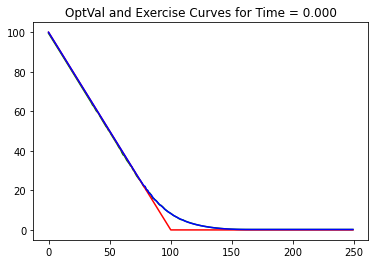

Opt Action = False, Opt Val = 8.257

Time 1



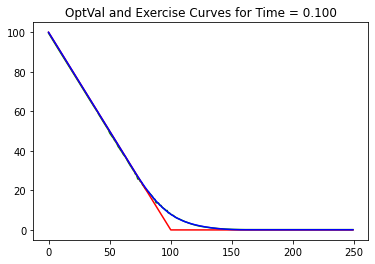

Opt Action = False, Opt Val = 7.919

Time 2



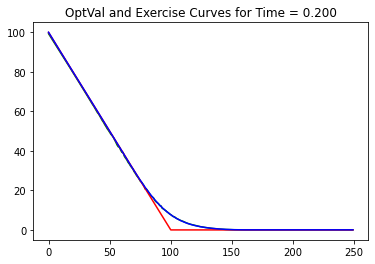

Opt Action = False, Opt Val = 7.677

Time 3



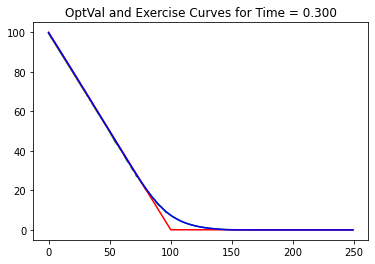

Opt Action = False, Opt Val = 7.346

Time 4



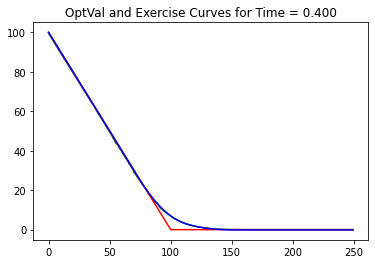

Opt Action = False, Opt Val = 6.931

Time 5



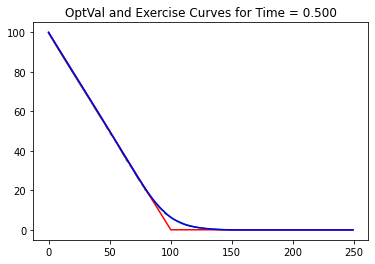

Opt Action = False, Opt Val = 6.357

Time 6



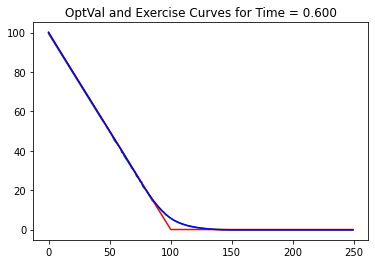

Opt Action = False, Opt Val = 5.737

Time 7



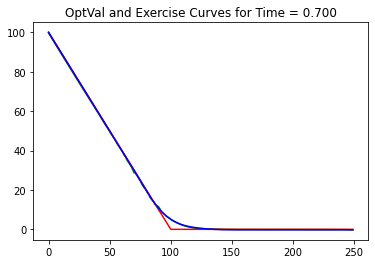

Opt Action = False, Opt Val = 5.123

Time 8



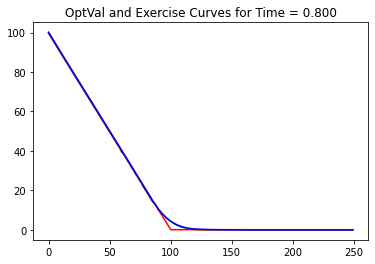

Opt Action = False, Opt Val = 4.303

Time 9



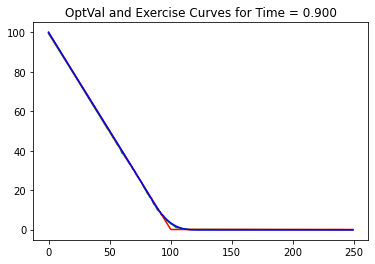

Opt Action = False, Opt Val = 3.361

Time 10



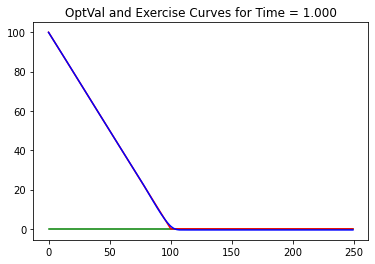

Opt Action = False, Opt Val = 1.333



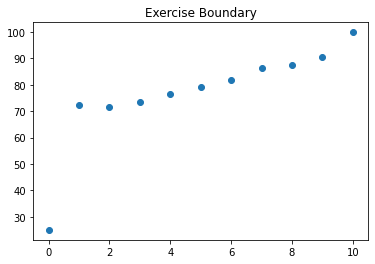

American Put Price using ADP
------------------
8.256783143102883

European Put Price using B-S
------------------
7.458941380440123



In [80]:
# put option

spot_price_val: float = 100.0 #100
strike: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.01 #0.02
    
is_call: bool = False
    
# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda x: max(x - strike, 0)
else:
    opt_payoff = lambda x: max(strike - x, 0)

opt_ex_bi: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val,
    spot_price_frac=spot_price_frac_val
)

# here I used to get an iterator of the optimal value functions and the associated optimal policy,
# but now I get an iterator of the continuation value functions, the optimal value function, and the optimal policy for this step
# when plotting the following, you should observe that the payoff function crosses the continuation at the policy number.
it_vf = opt_ex_bi.backward_induction_vf_and_pi(is_call)

print("Backward Induction: VF And Policy")
print("---------------------------------")
print()
prices: np.ndarray = np.arange(250.0)
all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, v_cont, v_exec, p) in enumerate(it_vf):

    print(f"Time {t:d}")
    print()

    # plot the continuation value function at time t(value function if action = False)
    v_cont_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_cont,
        prices=prices
    )

    plt.plot(
        prices,
        v_cont_curve,
        "g"
    )


    # plot the execution value function at time t(value function if action = True)
    v_exec_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_exec,
        prices=prices
    )

    plt.plot(
        prices,
        [opt_payoff(p) for p in prices],
        "r"
    )

    # plot the optimal value function at time t
    v_opt_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_opt,
        prices=prices
    )

    plt.plot(
        prices,
        v_opt_curve,
        color = "b"
    )


    time: float = t * expiry_val / num_steps_val
    plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
    plt.show()

    all_funcs.append(v_opt)

    opt_alloc: float = p.action_for(spot_price_val)
    val: float = v_opt(NonTerminal(spot_price_val))
    print(f"Opt Action = {opt_alloc}, Opt Val = {val:.3f}")
    print()
        
if not is_call:
    ex_bound: Sequence[float] = opt_ex_bi.put_option_exercise_boundary(
        all_funcs,
        strike
    )
    plt.scatter(range(num_steps_val + 1), ex_bound)
    plt.title("Exercise Boundary")
    plt.show()
    
    val:float = all_funcs[0](NonTerminal(spot_price_val))
    print(f"American Put Price using ADP")
    print("------------------")
    print(val)
    print()
    
    print("European Put Price using B-S")
    print("------------------")
    print(opt_ex_bi.european_price(is_call=is_call, strike=strike))
    print()

else:
    # TODO: it seems like the call option work better with ADP when the num_state_samples=100, when it is 
    # around 1000, the results are worse, and bspline complains that the smoothing s is too small (RuntimeError: A theoretically 
    # impossible result when finding a smoothing spline)

    v_opt = all_funcs[0]
    val:float = v_opt(NonTerminal(spot_price_val))
    print(f"American Call Price using ADP")
    print("------------------")
    print(val)
    print()
    
    print("European Call Price using B-S")
    print("------------------")
    print(opt_ex_bi.european_price(is_call=is_call, strike=strike))
    print()

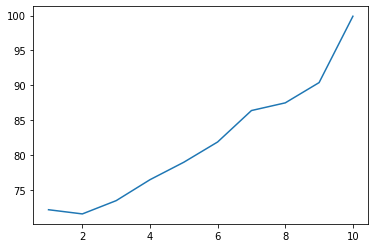

In [85]:
plt.plot(range(1,num_steps_val + 1), ex_bound[1:])

In [44]:
# ex_bound_s25_p8219 = copy.deepcopy(ex_bound)
# all_funcs_s25_p8219 = copy.deepcopy(all_funcs)

In [ ]:
all_funcs_

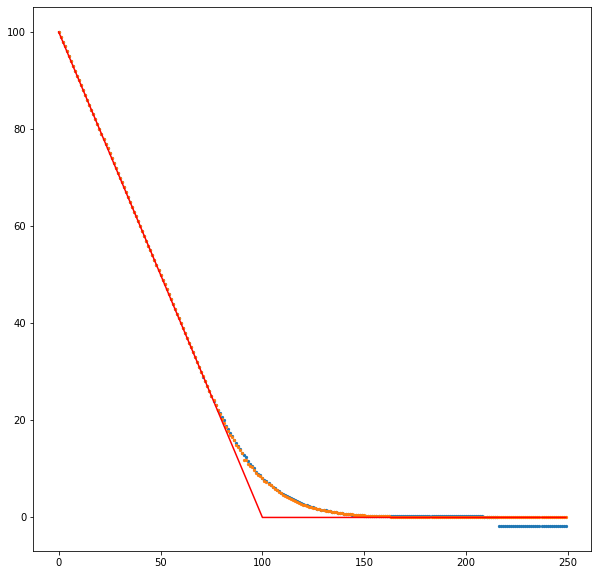

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(prices, all_funcs_s25_p8219[0].evaluate([NonTerminal(p) for p in prices]), s=5)
plt.scatter(prices, all_funcs_s10_p8033[0].evaluate([NonTerminal(p) for p in prices]), s=5)
plt.plot(prices,[max(0,100-p) for p in prices],color="red")
plt.legend("")
plt.show()

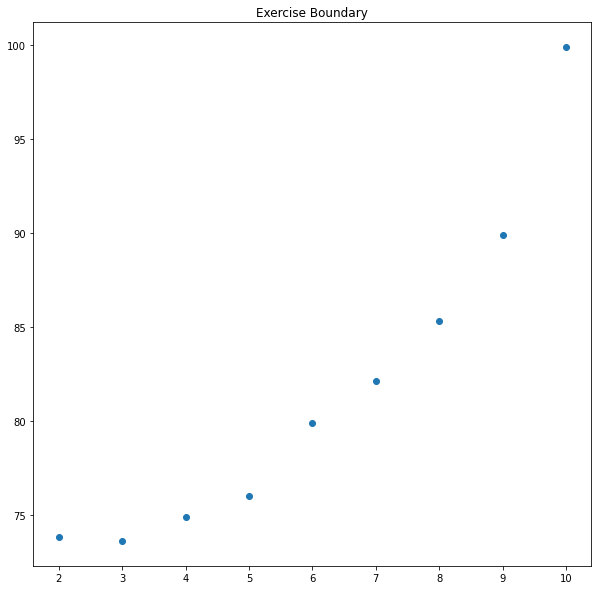

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(range(num_steps_val + 1)[2:], ex_bound_s25_p8219[2:])
plt.title("Exercise Boundary")
plt.show()

# linear interpolation (my first approach and not the best)

Backward Induction: VF And Policy
---------------------------------

Time 0



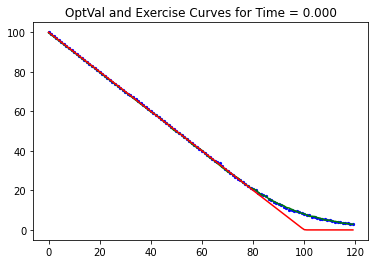

Opt Action = False, Opt Val = 7.974

Time 1



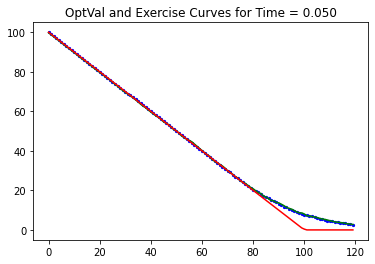

Opt Action = False, Opt Val = 7.791

Time 2



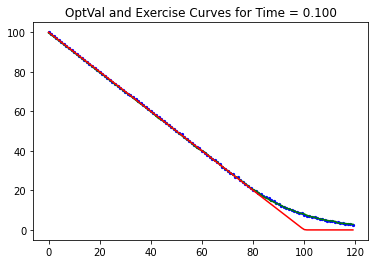

Opt Action = False, Opt Val = 7.602

Time 3



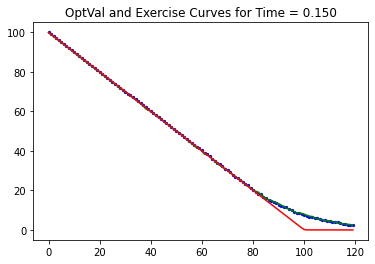

Opt Action = False, Opt Val = 7.521

Time 4



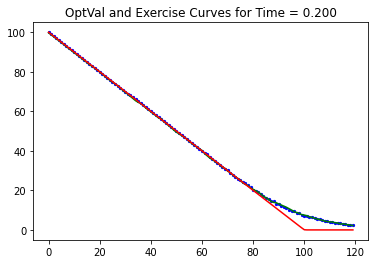

Opt Action = False, Opt Val = 7.139

Time 5



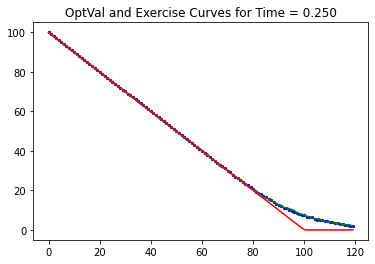

Opt Action = False, Opt Val = 7.484

Time 6



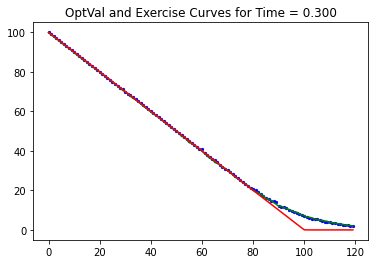

Opt Action = False, Opt Val = 6.914

Time 7



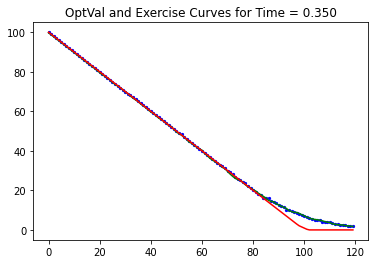

Opt Action = False, Opt Val = 7.018

Time 8



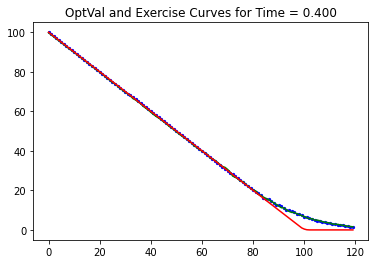

Opt Action = False, Opt Val = 6.556

Time 9



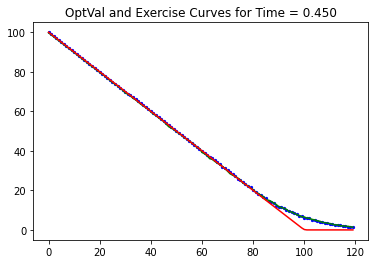

Opt Action = False, Opt Val = 6.091

Time 10



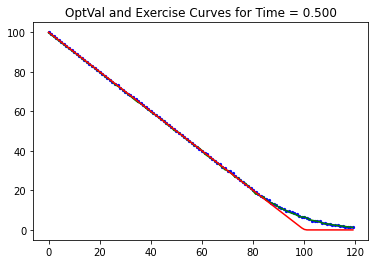

Opt Action = False, Opt Val = 6.291

Time 11



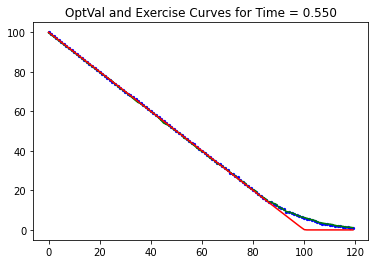

Opt Action = False, Opt Val = 5.976

Time 12



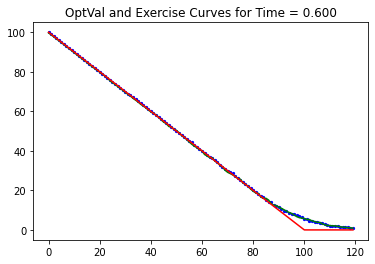

Opt Action = False, Opt Val = 5.637

Time 13



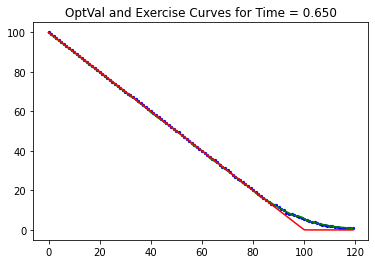

Opt Action = False, Opt Val = 5.699

Time 14



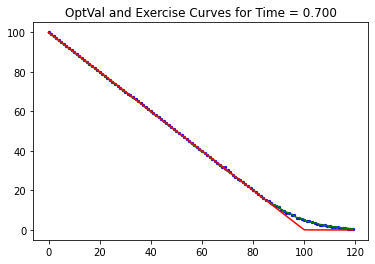

Opt Action = False, Opt Val = 5.072

Time 15



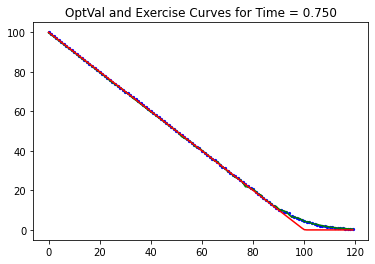

Opt Action = False, Opt Val = 4.634

Time 16



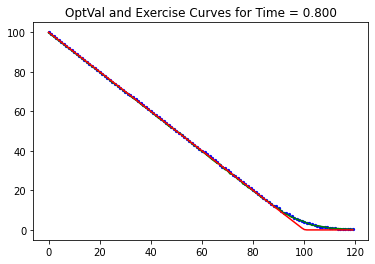

Opt Action = False, Opt Val = 4.198

Time 17



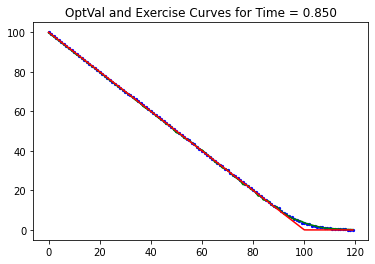

Opt Action = False, Opt Val = 3.543

Time 18



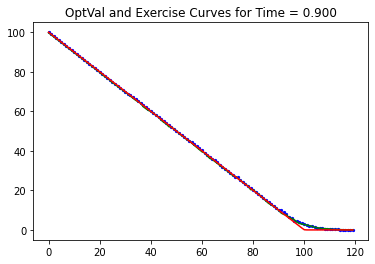

Opt Action = False, Opt Val = 3.015

Time 19



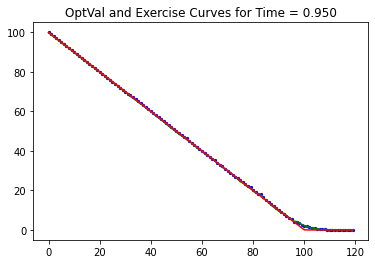

Opt Action = False, Opt Val = 1.906

Time 20



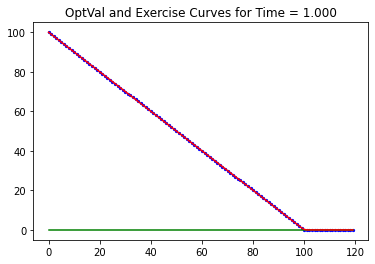

Opt Action = False, Opt Val = 0.029



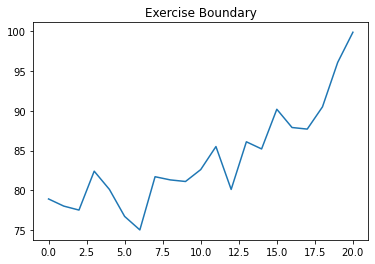

European Put Price
------------------

7.458941380440123


In [8]:
# the following was modified to allow for linear interpolation


@dataclass(frozen=True)
class OptimalExerciseBI:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float

    def european_put_price(self, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        return strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) \
            - self.spot_price * norm.cdf(-d1)

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseBIMDP(MarkovDecisionProcess[float, bool]):

            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=100 # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseBIMDP()

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
                self.vol * np.sqrt(time)
#                 self.vol * np.sqrt(time)*1.1  # I modified this line to have more variance (added the *1.1)
            ))
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)

# the function below is not needed anymore

#     def get_vf_func_approx(
#         self,
#         t: int,
#         features: Sequence[Callable[[NonTerminal[float]], float]],
#         reg_coeff: float
#     ) -> LinearFunctionApprox[NonTerminal[float]]:
#         return LinearFunctionApprox.create(
#             feature_functions=features,
#             regularization_coeff=reg_coeff,
#             direct_solve=True
#         )

    # this was modified to allow for linear interpolation
    def backward_induction_vf_and_pi(
        self
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[float, bool],
            FunctionApprox[NonTerminal[float]],
            SampledDistribution[NonTerminal[float]]
        ]] = [(
            self.get_mdp(t=i),
            LinearInterpolationApprox(feature_function=lambda s: s.state, mode="decreasing"),
            self.get_states_distribution(t=i)
        ) for i in range(self.num_steps + 1)]

        num_state_samples: int = 1000 #1000

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=np.exp(-self.rate * self.expiry / self.num_steps),
            num_state_samples=num_state_samples,
            error_tolerance=1e-8,
            mode = "put"
        )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    # I modifed this function to add a tolerance
    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float,
        tol: float = 1e-1
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e+tol > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret





############################################################################################




spot_price_val: float = 100.0 #100
strike: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.5
vol_val: float = 0.25 #0.25
num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.0 #0.02

opt_ex_bi: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=lambda x: max(strike - x, 0.),
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val,
    spot_price_frac=spot_price_frac_val
)

# here I used to get an iterator of the optimal value functions and the associated optimal policy,
# but now I get an iterator of the continuation value functions, the optimal value function, and the optimal policy for this step
# when plotting the following, you should observe that the payoff function crosses the continuation at the policy number.
it_vf = opt_ex_bi.backward_induction_vf_and_pi()

prices: np.ndarray = np.arange(150.0)

print("Backward Induction: VF And Policy")
print("---------------------------------")
print()

all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, v_cont, v_exec, p) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()

    # plot the continuation value function at time t(value function if action = False)
    v_cont_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_cont,
        prices=prices
    )

    plt.plot(
        prices,
        v_cont_curve,
        "g"
    )

    
    # plot the execution value function at time t(value function if action = True)
    v_exec_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_exec,
        prices=prices
    )

    plt.plot(
        prices,
        v_exec_curve,
        "r"
    )
    
    # plot the optimal value function at time t
    v_opt_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v_opt,
        prices=prices
    )

    plt.scatter(
        prices,
        v_opt_curve,
        color = "b",
        s = 5
    )


    time: float = t * expiry_val / num_steps_val
    plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
    plt.show()

    all_funcs.append(v_opt)

    opt_alloc: float = p.action_for(spot_price_val)
    val: float = v_opt(NonTerminal(spot_price_val))
    print(f"Opt Action = {opt_alloc}, Opt Val = {val:.3f}")
    print()

ex_bound: Sequence[float] = opt_ex_bi.put_option_exercise_boundary(
    all_funcs,
    strike
)
plt.plot(range(num_steps_val + 1), ex_bound)
plt.title("Exercise Boundary")
plt.show()

print("European Put Price")
print("------------------")
print()
print(opt_ex_bi.european_put_price(strike=strike))


# other viz

Time 0



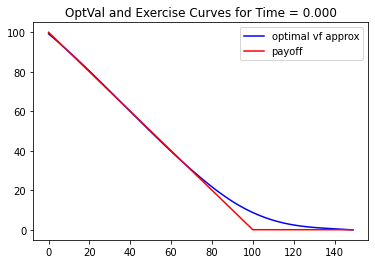


Time 1



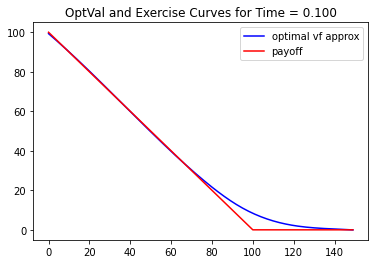


Time 2



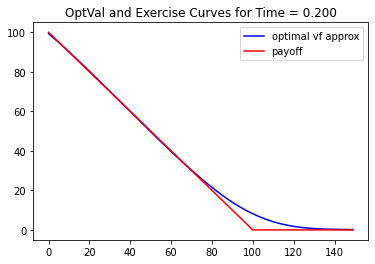


Time 3



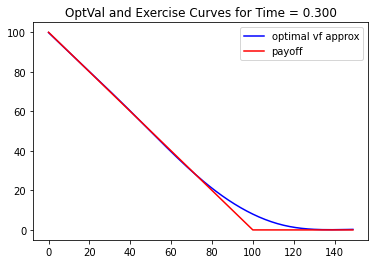


Time 4



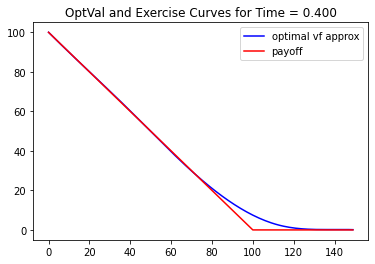


Time 5



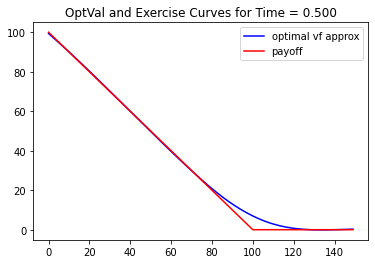


Time 6



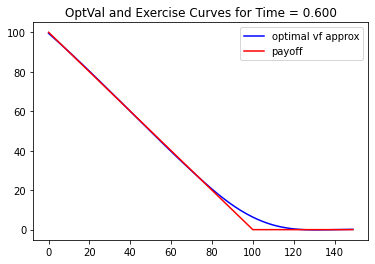


Time 7



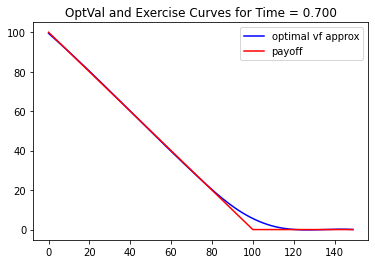


Time 8



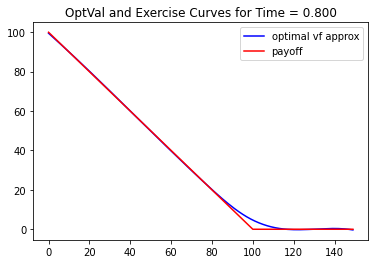


Time 9



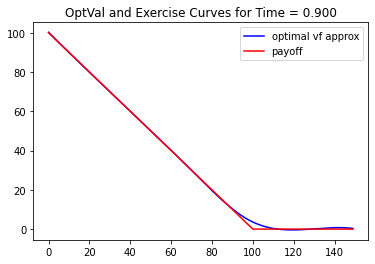


Time 10



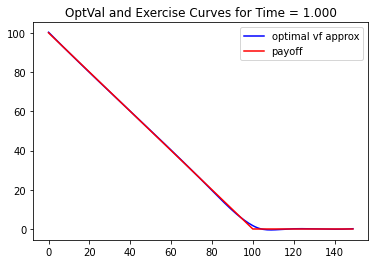

In [10]:
prices: np.ndarray = np.arange(150.0)
for t, v in enumerate(all_funcs):
    print(f"Time {t:d}")
    print()

    opt_val_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
        func=v,
        prices=prices
    )

#     if t == 2:
#         print(list(zip(prices,opt_val_curve, [max(0,100-x) for x in prices])))
#         print()
    
    plt.plot(
        prices,
        opt_val_curve,
        color = "b",
        label = "optimal vf approx"
    )

    plt.plot(
        prices,
        [max(0, 100 - price) for price in prices],
        color = "red",
        label = "payoff")

    plt.legend(loc="best")


    time: float = t * expiry_val / num_steps_val
    plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
    plt.show()

#     opt_alloc: float = p.action_for(spot_price_val)
#     val: float = v(NonTerminal(spot_price_val))
#     print(f"Opt Action = {opt_alloc}, Opt Val = {val:.3f}")
    print()

# linear function approximation code (almost original)

In [ ]:
# (almost) original code using linear function approximation


@dataclass(frozen=True)
class OptimalExerciseBI:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float

    def european_put_price(self, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        return strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) \
            - self.spot_price * norm.cdf(-d1)

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseBIMDP(MarkovDecisionProcess[float, bool]):

            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=200 # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseBIMDP()

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
                self.vol * np.sqrt(time)
#                 self.vol * np.sqrt(time)*1.1  # I modified this line to have more variance (added the *1.1)
            ))
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)

    def get_vf_func_approx(
        self,
        t: int,
        features: Sequence[Callable[[NonTerminal[float]], float]],
        reg_coeff: float
    ) -> LinearFunctionApprox[NonTerminal[float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            regularization_coeff=reg_coeff,
            direct_solve=True
        )

    def backward_induction_vf_and_pi(
        self,
        features: Sequence[Callable[[NonTerminal[float]], float]],
        reg_coeff: float
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[float, bool],
            FunctionApprox[NonTerminal[float]],
            SampledDistribution[NonTerminal[float]]
        ]] = [(
            self.get_mdp(t=i),
            self.get_vf_func_approx(
                t=i,
                features=features,
                reg_coeff=reg_coeff
            ),
            self.get_states_distribution(t=i)
        ) for i in range(self.num_steps + 1)]

        num_state_samples: int = 1000 #1000

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=np.exp(-self.rate * self.expiry / self.num_steps),
            num_state_samples=num_state_samples,
            error_tolerance=1e-8,
            mode = "put"
        )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret





############################################################################################




spot_price_val: float = 100.0 #100
strike: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.5
vol_val: float = 0.25 #0.25
num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.02 #0.02

opt_ex_bi: OptimalExerciseBI = OptimalExerciseBI(
    spot_price=spot_price_val,
    payoff=lambda x: max(strike - x, 0.),
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val,
    spot_price_frac=spot_price_frac_val
)

num_laguerre: int = 4 # 4
reglr_coeff: float = 0.01 #0.001 (I should play with that)

ident: np.ndarray = np.eye(num_laguerre)
ffs: List[Callable[[NonTerminal[float]], float]] = [lambda _: 1.]
ffs += [(lambda s: np.log(1 + np.exp(-s.state / (2 * strike))) *
        lagval(s.state / strike, ident[i]))
        for i in range(num_laguerre)]
# adding this line to add the payoff function as a feature function (and more)
# ffs += [lambda s: max(strike - s.state, 0.)]
# ffs += [(lambda s: (strike - s.state)**i) # me trying out with polynomial features
#         for i in range(4)]
# ffs += [(lambda s: (strike - s.state)**i if s.state > strike else 0) # me trying out with (asymetric) polynomial features
#         for i in range(4)]

# ffs += [(lambda s: (strike - s.state)**i if s.state <= strike else 0) # me trying out with (asymetric) polynomial features
#         for i in range(5)]

# trying to add some smooth functions that look like the payoff

it_vf = opt_ex_bi.backward_induction_vf_and_pi(
    features=ffs,
    reg_coeff=reglr_coeff
)

prices: np.ndarray = np.arange(120.0)

print("Backward Induction: VF And Policy")
print("---------------------------------")
print()

all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v, p) in enumerate(it_vf):
    print(f"Time {t:d}")
    print()

#         if t == 0 or t == int(num_steps_val / 2) or t == num_steps_val - 1:
    if True:
#         exer_curve: np.ndarray = opt_ex_bi.exercise_curve(
#             prices=prices
#         )
        opt_val_curve: np.ndarray = opt_ex_bi.optimal_value_curve(
            func=v,
            prices=prices
        )
#             plt.plot(
#                 prices,
#                 opt_val_curve,
#                 "r",
#                 prices,
#                 exer_curve,
#                 "b"
#             )
        plt.plot(
            prices,
            opt_val_curve,
            "r"
        )
    
    

        time: float = t * expiry_val / num_steps_val
        plt.title(f"OptVal and Exercise Curves for Time = {time:.3f}")
        plt.show()

    all_funcs.append(v)

    opt_alloc: float = p.action_for(spot_price_val)
    val: float = v(NonTerminal(spot_price_val))
    print(f"Opt Action = {opt_alloc}, Opt Val = {val:.3f}")
    print()

ex_bound: Sequence[float] = opt_ex_bi.put_option_exercise_boundary(
    all_funcs,
    strike
)
plt.plot(range(num_steps_val + 1), ex_bound)
plt.title("Exercise Boundary")
plt.show()

print("European Put Price")
print("------------------")
print()
print(opt_ex_bi.european_put_price(strike=strike))
